1. [x] Load participants' data in both experiments, and learn associative transition to generate predicted probabilities.
2. [x] Use these probabilities to get the negative log reaction time simulations, and then use mixture of gaussian models to classify within and between chunk reaction times
3. [x] Identify chunk size as a function of trial number  (trialnumber, ID, condition, chunksize)
4. [x] Use the classified reaction time to generate data for associative learning model such as the chunk growth rate during the training trials. 
5. [x] Plot the moving average of chunk size as a function of trial number
6. [x] Evaluate average chunk size increase rate 


In [1]:
import pandas as pd
from PARSER import *
from utils import *
import matplotlib
import matplotlib.pyplot as plt

# Transition probabilities

In [2]:
T = np.zeros((4,4))
T[[0,2],:] = 0.1/3
T[[1,3],:] = 0.1
T[[0,2],[1,3]] = 0.9
T[[1,3],[2,0]] = 0.7
X = ['A','B','C','D']

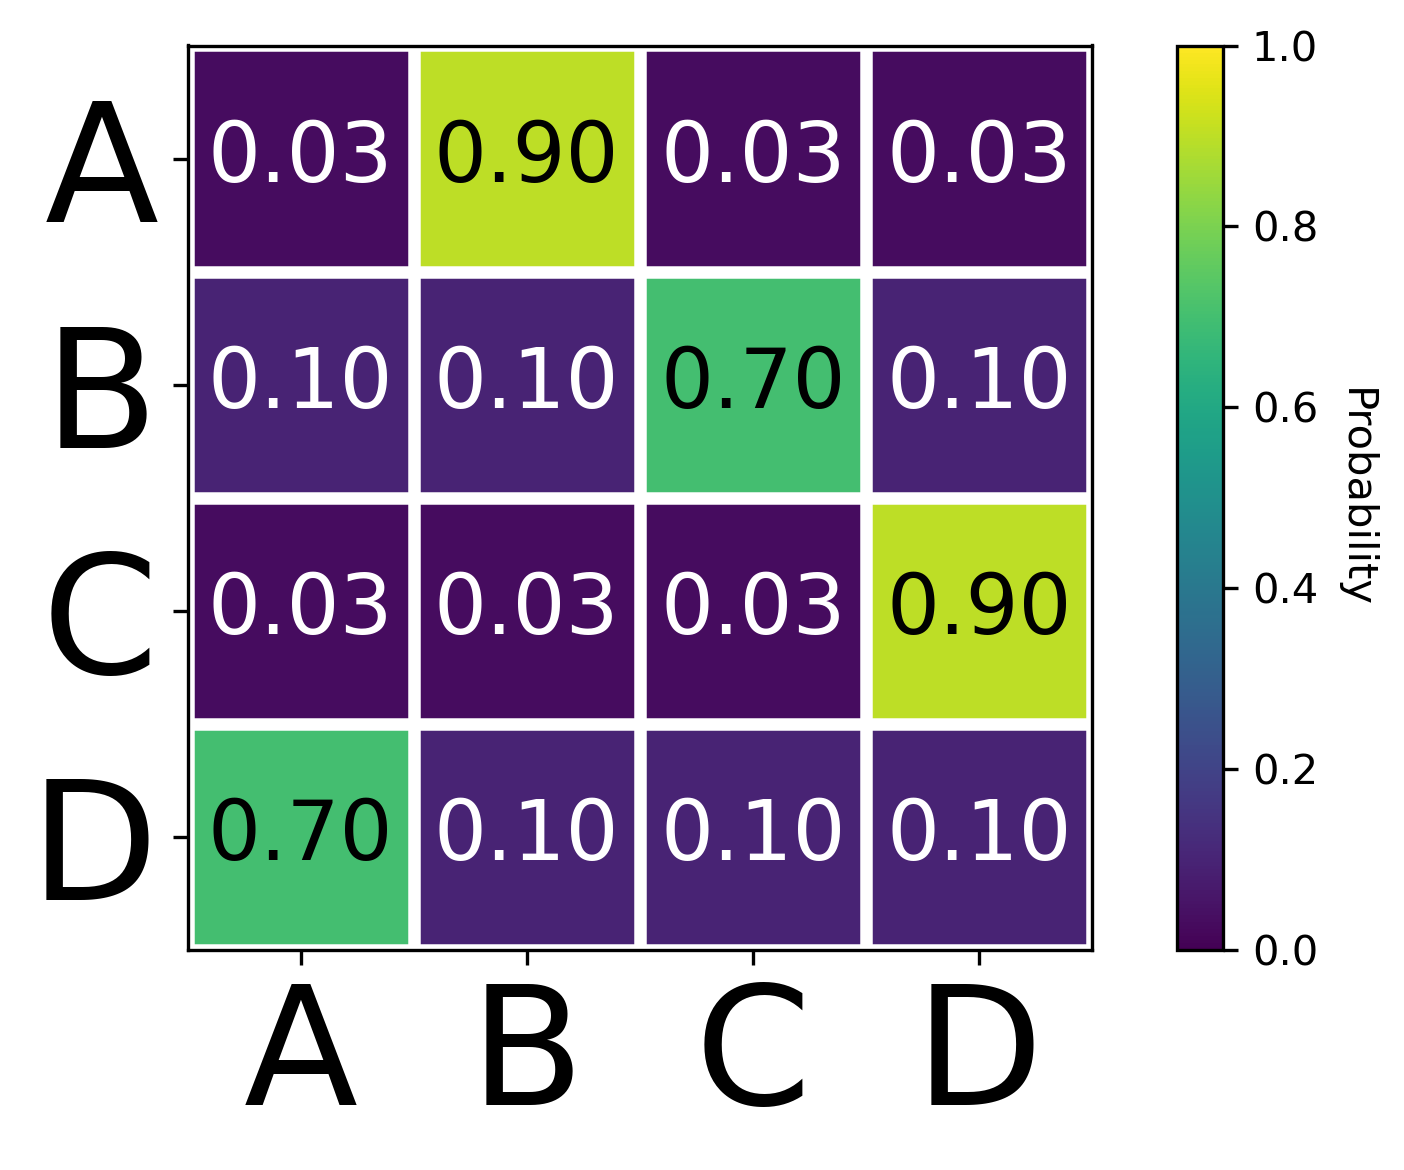

In [3]:
fig, ax = plt.subplots(dpi = 300)
im, cbar = heatmap(T, X, X, ax=ax,
                   cmap="viridis", cbarlabel="Probability",vmin=0, vmax=1)
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
#plt.show()
plt.savefig('../figure/transitionaccurate')

In [4]:
T = np.zeros((4,4))
T[[0,2],[1,3]] = 1.0
T[[1,3],[2,0]] = 1.0
X = ['A','B','C','D']
T

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

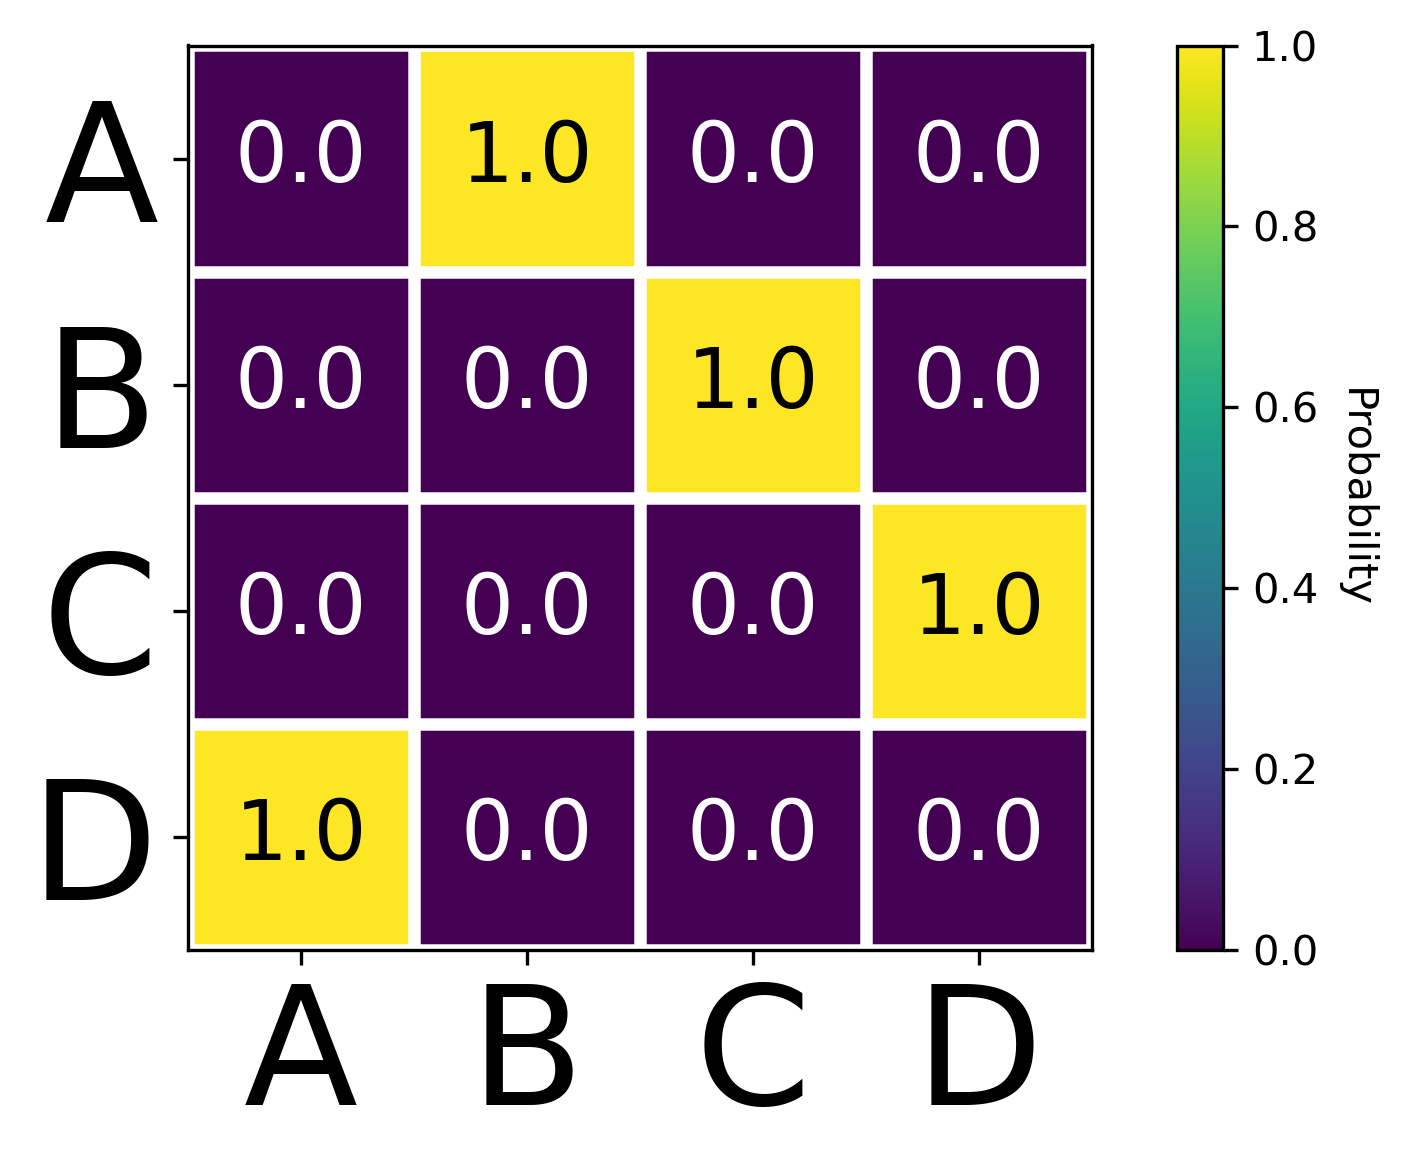

In [5]:
fig, ax = plt.subplots(dpi = 300)
im, cbar = heatmap(T, X, X, ax=ax,
                   cmap="viridis", cbarlabel="Probability")
texts = annotate_heatmap(im, valfmt="{x:.1f}")
fig.tight_layout()
#plt.show()
plt.savefig('../figure/transitionfast')

In [6]:
T = np.ones((4,4))
T = T*0.25
X = ['A','B','C','D']
T

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

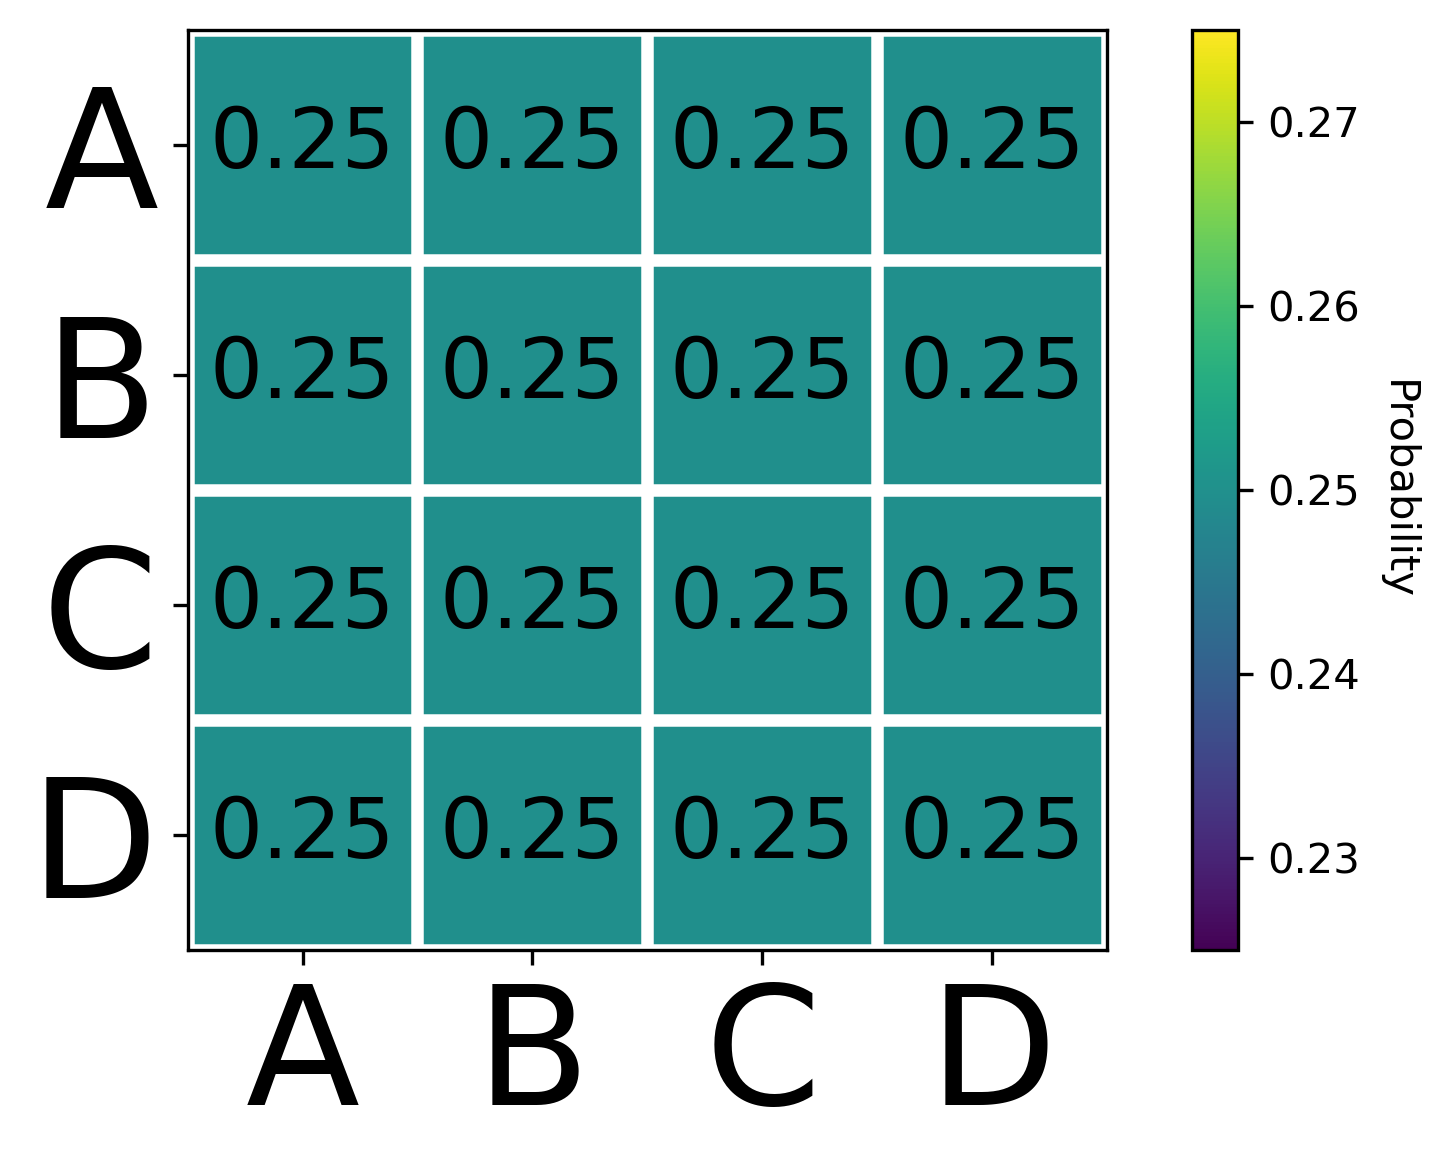

In [7]:
fig, ax = plt.subplots(dpi = 300)
im, cbar = heatmap(T, X, X, ax=ax,
                   cmap="viridis", cbarlabel="Probability")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
#plt.show()
plt.savefig('../figure/transitionind')

# Size 2 condition

In [8]:
# ground truth transition probability
T_ab = np.zeros((4,4))
T_ab[0,1] = 1
X = ['A','B','C','D']
T_ab[1,[0,2,3]] = 1/3
T_ab[2,[0,2,3]] = 1/3
T_ab[3,[0,2,3]] = 1/3
T_ab

array([[0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333]])

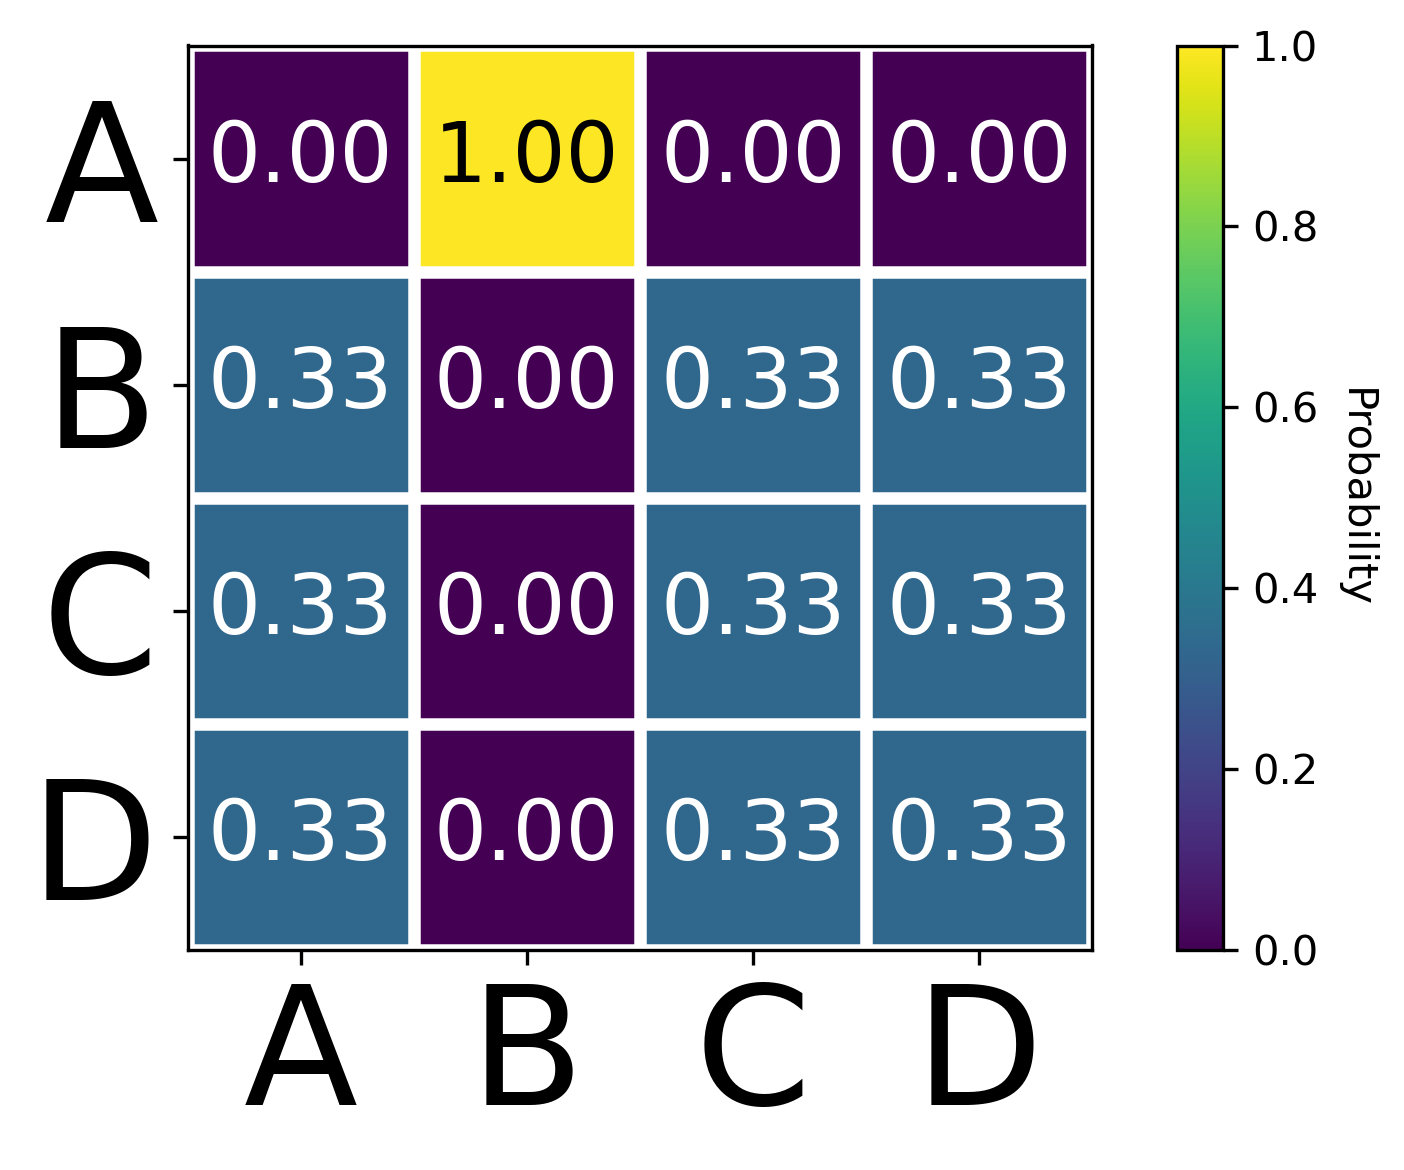

In [9]:
fig, ax = plt.subplots(dpi = 300)
im, cbar = heatmap(T_ab, X, X, ax=ax,
                   cmap="viridis", cbarlabel="Probability")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
#plt.show()
plt.savefig('../figure/transitionsize2')

In [10]:
# ground truth transition probability
X = ['A','B','C','D']
T_abc = np.zeros((4,4))
T_abc[0,1] = 1
T_abc[1,2] = 1
T_abc[2,[0,3]] = 1/2
T_abc[3,[0,3]] = 1/2
T_abc

array([[0. , 1. , 0. , 0. ],
       [0. , 0. , 1. , 0. ],
       [0.5, 0. , 0. , 0.5],
       [0.5, 0. , 0. , 0.5]])

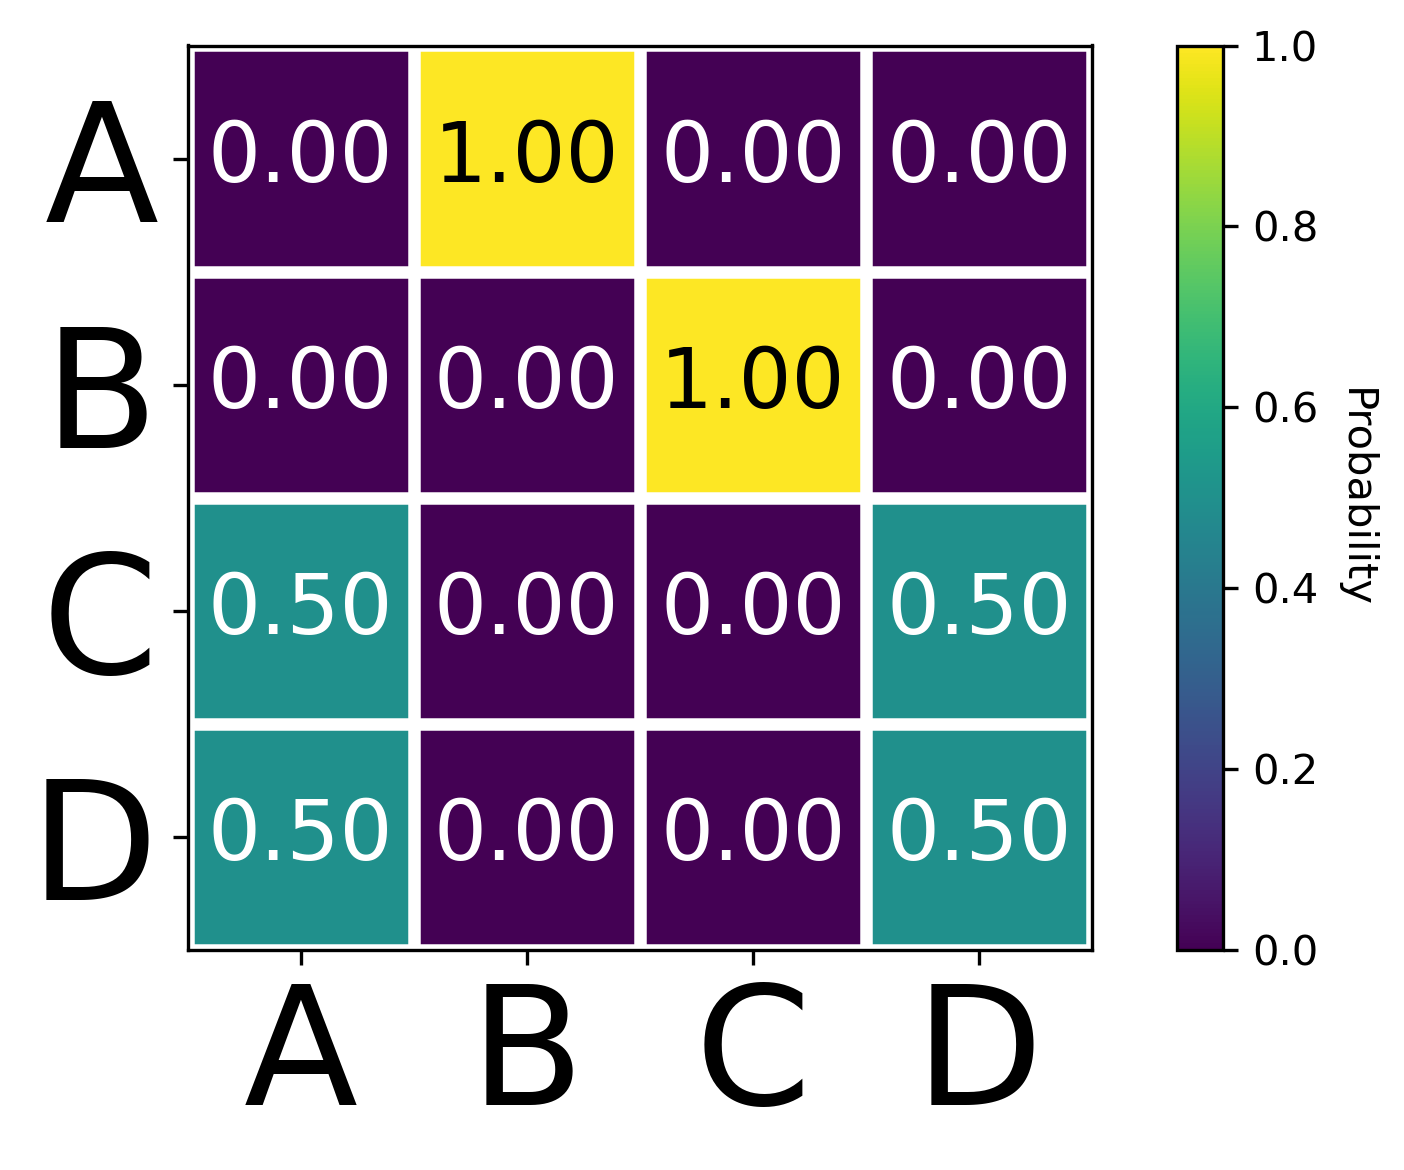

In [11]:
fig, ax = plt.subplots(dpi = 300)
im, cbar = heatmap(T_abc, X, X, ax=ax,
                   cmap="viridis", cbarlabel="Probability")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
#plt.show()
plt.savefig('../figure/transitionsize3')

In [12]:
def associative_learning(seq, theta=1):
    ''' A first order associative learning model'''
    # theta: forgetting rate
    transition={}
    for i in [1,2,3,4]:
        transition[i] = {}
        for j in [1,2,3,4]:
            transition[i][j] = 0
    p = [0.25] # initialize the first probability to be the most entropic
    
    for i in range(1,len(seq)):
        prev = seq[i-1]
        curr = seq[i]
        transition[prev][curr] = (transition[prev][curr] + 1)*theta
        p.append(transition[prev][curr]/sum(transition[prev].values()))
        
    return p
        
    
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def learn_gaussian_mixture(X,n_mixture = 3):
    N = [n_mixture] #np.arange(1, 11)
    models = [None for i in range(len(N))]

    for i in range(len(N)):
        models[i] = GaussianMixture(N[i]).fit(X)

    # compute the AIC and the BIC
    AIC = [m.aic(X) for m in models]
    BIC = [m.bic(X) for m in models]

    return AIC, BIC, models

    
def mixture_gaussian_classification(time_collect, seql = 1000):
    # group level behavioral comparison: 
    within_chunk = np.zeros([1*seql], dtype =bool)
    p_within_chunk = np.zeros([1*seql])
    
    AIC, BIC, model = learn_gaussian_mixture(time_collect,n_mixture = 2)
    model = model[0]
    within_chunk_model_index = np.argmin(model.means_)
    reaction_time = np.array(time_collect)
    responsibilities = model.predict_proba(reaction_time.reshape(-1, 1))# likelihood of belonging to which gaussian mixture
    prediction = model.predict(reaction_time.reshape(-1, 1))# likelihood of belonging to which gaussian mixture
    within_chunk = (prediction == within_chunk_model_index)
    p_within_chunk = responsibilities[:,within_chunk_model_index]
    return p_within_chunk, within_chunk


def identify_key_seq(subject_id, blocks, dataframe):
    '''returns the translated keyinstruction, key press, in [1,2,3,4] integers across the defined range of blocks '''
    instruction = []
    press = []
    thisrt = []
    for block in blocks:
        for trial in range(1,101):
            index = dataframe.index[(dataframe['id'] == subject_id) & (dataframe['trialcollect'] == trial) & (dataframe['block'] == block)].tolist()[0]
            keypress = identify_press(dataframe, keydff, index)
            inst = identify_inst(dataframe, keydff, index)
            press.append(keypress)
            instruction.append(inst)
            thisrt.append(dataframe[(dataframe['id'] == subject_id) & (dataframe['trialcollect'] == trial) & (dataframe['block'] == block)]['timecollect'].tolist()[0])
    return instruction, press, thisrt


In [13]:
dfsubject = pd.read_csv('../Data/filtered_exp1.csv')
dfsubject.head()

,id,keyassignment,condition,trialcollect,trialinstruction,instructioncollect,userpress,timecollect,correctcollect,block
0,1,"['K', 'J', 'F', 'D']",2,1,n,D,D,1375,1,1
1,1,"['K', 'J', 'F', 'D']",2,2,n,K,K,1960,1,1
2,1,"['K', 'J', 'F', 'D']",2,3,n,J,J,1043,1,1
3,1,"['K', 'J', 'F', 'D']",2,4,n,F,F,718,1,1
4,1,"['K', 'J', 'F', 'D']",2,5,n,D,D,568,1,1


# Associative Learning and Chunk Classification on Instruction Data

In [15]:
dfsubject = pd.read_csv('../Data/filtered_exp1.csv')
data = {}
data['id'] = []
data['block'] = []
data['associative_learning_p'] = []
data['associative_learning_log_p'] = []
data['withinchunk'] = []
data['p_within_chunk'] = []
data['trialcollect'] = []
data['condition'] = []
data['block'] = []
data['seq'] = []
data['subject_rt'] = []
data['keyassignment'] = []
data['userpress'] = []

for cond in [0,1,2]:
    for subj in np.unique(dfsubject[dfsubject['condition'] == cond]['id']):# iterate over all subjects in c3 chunk condition
        subseq = []
        for press in list(dfsubject[dfsubject['id'] == subj]['instructioncollect']):
            if press == list(dfsubject[dfsubject['id'] == subj]['keyassignment'])[0][2]:
                subseq.append(1)
            if press == list(dfsubject[dfsubject['id'] == subj]['keyassignment'])[0][7]:
                subseq.append(2)
            if press == list(dfsubject[dfsubject['id'] == subj]['keyassignment'])[0][12]:
                subseq.append(3)
            if press == list(dfsubject[dfsubject['id'] == subj]['keyassignment'])[0][17]:
                subseq.append(4)
        seq = subseq[:1000]       
        # only record data during training 
        data['id'] += [subj]*1000
        data['subject_rt'] += list(dfsubject[dfsubject['id'] == subj]['timecollect'])[:1000]
        data['seq'] += seq
        data['condition'] += [cond]*1000
        data['trialcollect'] += list(range(1,101,1))*10
        data['block']+= list(np.repeat(list(range(1,11,1)),100))
        
        p_associative_learning = associative_learning(seq)
        data['associative_learning_p'] += p_associative_learning
        neglogp = list(-np.log(p_associative_learning))
        data['associative_learning_log_p'] += neglogp
        p_within_chunk, within_chunk = mixture_gaussian_classification(np.array(neglogp).reshape(-1,1), seql = 1000)
        data['withinchunk'] += list(within_chunk)
        data['p_within_chunk'] += list(p_within_chunk)
        data['keyassignment']+= list(dfsubject[dfsubject['id'] == subj]['keyassignment'][0:1000])
        data['userpress'] += list(dfsubject[dfsubject['id'] == subj]['userpress'][0:1000])
        
df = pd.DataFrame(data=data)
df.to_csv('../Data/exp1_associative_learning_rt_classified.csv')

In [13]:
df = pd.read_csv('../Data/exp1_associative_learning_rt_classified.csv')

In [26]:
indep_chunks_al, c2_chunks_al, c3_chunks_al = process_experiment1_into_chunks_by_condition('../Data/exp1_associative_learning_rt_classified.csv')
chunks_ts_al = {}
chunks_ts_al['ind'] = {}
chunks_ts_al['ind']['chunk'] = indep_chunks_al
chunks_ts_al['c2'] = {}
chunks_ts_al['c2']['chunk'] = c2_chunks_al
chunks_ts_al['c3'] = {}
chunks_ts_al['c3']['chunk'] = c3_chunks_al


# dataframe with the length of chunks, sequence
dat = {}
dat['chunksize'] = []
dat['condition'] = []
dat['ID'] = []
dat['trialnumber'] = []

for condition in ['c2','c3','ind']:
    for ID in chunks_ts_al[condition]['chunk'].keys():
        chunklist = chunks_ts_al[condition]['chunk'][ID]
        tn = 1
        for chunk in chunklist:
            dat['chunksize'].append(len(chunk))
            dat['condition'].append(condition)
            dat['ID'].append(ID)
            dat['trialnumber'].append(tn)
            tn = tn + len(chunk)
            
dff = pd.DataFrame(data=dat)
dff.to_csv('../Data/associative_learning_chunksize_trialnumber.csv')


Do the same thing for a rational chunk learning model 

1. [x] Get the simulated rational chunk learning model
2. [x] the simulated reaction time
3. [x] The simulated within-chunk vs. between-chunk classification

In [239]:
dfsubject = pd.read_csv('../Data/filtered_exp1.csv')

data = {}
data['id'] = []

w = 0.1
name = 'rational_chunking_rt w = ' + str(w)
data[name] = []    

data['seq'] = []
data['cond'] = []
data['block'] = []
data['subject_rt'] = []
data['userpress'] = []
data['keyassignment'] = []
data['p_within_chunk'] = []
data['within_chunk'] = []


for cond in [0,1,2]:
    for subj in np.unique(dfsubject[dfsubject['condition'] == cond]['id']):
        print('subj ', subj)
        subseq = []
        for press in list(dfsubject[dfsubject['id'] == subj]['instructioncollect']):
            if press == list(dfsubject[dfsubject['id'] == subj]['keyassignment'])[0][2]:
                subseq.append(1)
            if press == list(dfsubject[dfsubject['id'] == subj]['keyassignment'])[0][7]:
                subseq.append(2)
            if press == list(dfsubject[dfsubject['id'] == subj]['keyassignment'])[0][12]:
                subseq.append(3)
            if press == list(dfsubject[dfsubject['id'] == subj]['keyassignment'])[0][17]:
                subseq.append(4)
        seq = subseq[:1000]
        
        # only record data during training 
        data['id'] += [subj]*1000
        data['subject_rt'] += list(dfsubject[dfsubject['id'] == subj]['timecollect'])[:1000]
        data['seq'] += seq
        data['cond'] += [cond]*1000
        data['block']+= list(np.repeat(list(range(1,11,1)),100))
        
        ########## Use rational chunking model to learn from chunks ###########
        # store learned data like list of tuples 

        this_sequence = seq
        i = 0
        step = 1
        precord = []
        rtrecord = []
        # go through the sequence 10 units at a time
        
        while i<=1000:
            M,T,bagofchunk,rt,correctness,cp,reacted_press  = learn_sequence(this_sequence[:i], Print = False, w = w)
            correctness, rt, choice_probability,reacted_press,this_M, this_T = partition_seq_hastily(this_sequence,bagofchunk)
            rtrecord = rtrecord + rt[i:i+step]
            precord = precord + choice_probability[i:i+step]
            i = i + step
        data[name] += rtrecord
        p_within_chunk, within_chunk = mixture_gaussian_classification(np.array(rtrecord).reshape([-1,1]), seql = 1000)
        data['within_chunk'] += list(within_chunk)
        data['p_within_chunk'] += list(p_within_chunk)
        data['keyassignment']+= list(dfsubject[dfsubject['id'] == subj]['keyassignment'][0:1000])
        data['userpress'] += list(dfsubject[dfsubject['id'] == subj]['userpress'][0:1000])

        with open('../data/rational_chunking_rt_classified.pkl', 'wb') as f:
            pickle.dump(data, f)
            
            
df = pd.DataFrame.from_dict(data)
df = df.rename(columns={'cond': 'condition'})
df.loc[:, 'trialcollect'] = list(np.arange(1,101,1))*10*142
df.loc[:,'block'] = list(np.ravel([[i]*100 for i in range(1,11)]*142)) # each block has 100 trials, the block ranges from 1 to 10 for each participants, there are 142 participants in total
df = df.rename(columns={'within_chunk': 'withinchunk'})
df.to_csv('../data/rational_chunking_rt_classified.csv')  

subj  2


KeyboardInterrupt: 

In [211]:
indep_chunks_rc, c2_chunks_rc, c3_chunks_rc = process_experiment1_into_chunks_by_condition('../Data/rational_chunking_rt_classified.csv')

In [230]:
chunks_ts_rc = {}
chunks_ts_rc['ind'] = {}
chunks_ts_rc['ind']['chunk'] = indep_chunks_rc
chunks_ts_rc['c2'] = {}
chunks_ts_rc['c2']['chunk'] = c2_chunks_rc
chunks_ts_rc['c3'] = {}
chunks_ts_rc['c3']['chunk'] = c3_chunks_rc



# dataframe with the length of chunks, sequence
dat = {}
dat['chunksize'] = []
dat['condition'] = []
dat['ID'] = []
dat['trialnumber'] = []

for condition in ['c2','c3','ind']:
    for ID in chunks_ts_rc[condition]['chunk'].keys():
        chunklist = chunks_ts_rc[condition]['chunk'][ID]
        tn = 1
        for chunk in chunklist:
            dat['chunksize'].append(len(chunk))
            dat['condition'].append(condition)
            dat['ID'].append(ID)
            dat['trialnumber'].append(tn)
            tn = tn + len(chunk)
            
dff = pd.DataFrame(data=dat)
dff.to_csv('../Data/rational_chunking_chunksize_trialnumber.csv')

# Learning rate comparison

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [213]:
human_path = '../Data/chunksizetrialnumber.csv'
import pickle
with open(human_path, 'rb') as f:
    human_learn = pd.read_csv(f)

In [214]:
file = open('../Data/c3_chunks.pkl','rb')
c3subject = pickle.load(file)
file.close()
dfc3 = {}
dfc3['ID'] = []
dfc3['time'] = []
dfc3['chunksize'] = []
for ID in list(c3subject.keys()):
    L_ID = []
#     training_length = []
    tl = 0
    for i in range(0, len(c3subject[ID])):
        L = len(c3subject[ID][i])
        tl = tl + L
        if tl>200 and tl < 800: 
            dfc3['ID'].append(ID)
            dfc3['time'].append(tl)
            L_ID.append(L)
            dfc3['chunksize'].append(np.mean(L_ID[len(L_ID)-30:len(L_ID)]))
#             training_length.append(tl)
dfc3 = pd.DataFrame.from_dict(dfc3)
dfc3.to_pickle('../Data/dfc3.pkl')

In [215]:
file = open('../Data/c2_chunks.pkl','rb')
c2subject = pickle.load(file)
file.close()
dfc2 = {}
dfc2['ID'] = []
dfc2['time'] = []
dfc2['chunksize'] = []
for ID in list(c2subject.keys()):
    L_ID = []
#     training_length = []
    tl = 0
    for i in range(0, len(c2subject[ID])):
        L = len(c2subject[ID][i])
        tl = tl + L
        if tl>200 and tl < 800: 
            dfc2['ID'].append(ID)
            dfc2['time'].append(tl)
            L_ID.append(L)
            dfc2['chunksize'].append(np.mean(L_ID[len(L_ID)-30:len(L_ID)]))
#             training_length.append(tl)
dfc2 = pd.DataFrame.from_dict(dfc2)
dfc2.to_pickle('../Data/dfc2.pkl')

In [216]:
file = open('../Data/indep_chunks.pkl','rb')
indsubject = pickle.load(file)
file.close()
dfind = {}
dfind['ID'] = []
dfind['time'] = []
dfind['chunksize'] = []
for ID in list(indsubject.keys()):
    L_ID = []
#     training_length = []
    tl = 0
    for i in range(0, len(indsubject[ID])):
        L = len(indsubject[ID][i])
        tl = tl + L
        if tl>200 and tl < 800: 
            dfind['ID'].append(ID)
            dfind['time'].append(tl)
            L_ID.append(L)
            dfind['chunksize'].append(np.mean(L_ID[len(L_ID)-30:len(L_ID)]))
#             training_length.append(tl)
dfind = pd.DataFrame.from_dict(dfind)
dfind.to_pickle('../Data/dfind.pkl')

Text(0.5, 0, 'Time')

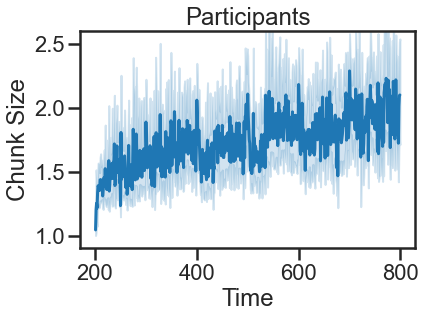

In [217]:
palette = sns.color_palette("tab10")
sns.set_style("ticks")
sns.set_context("paper")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="chunksize", color = palette[0], data=dfc3)
plt.title('Participants')
plt.ylim([0.9,2.6])
plt.ylabel('Chunk Size')
plt.xlabel('Time')


# Associative Learning Model

In [218]:
AL_path = '../Data/associative_learning_chunksize_trialnumber.csv'
import pickle
with open(AL_path, 'rb') as f:
    AL_learn = pd.read_csv(f)

In [219]:
AL_smoothed = []
for i in AL_learn.index.values.tolist():
    trialnumber = AL_learn.loc[i]['trialnumber']
    AL_learn_c = AL_learn.loc[i-30:i]
    if trialnumber < 31 : 
        AL_smoothed.append(np.mean(list(AL_learn_c[(AL_learn_c['trialnumber']>=1) & (AL_learn_c['trialnumber']<=trialnumber)]['chunksize'])))
    elif (trialnumber>=200 and trialnumber < 231): 
        AL_smoothed.append(np.mean(list(AL_learn_c[(AL_learn_c['trialnumber']>=200) & (AL_learn_c['trialnumber']<=trialnumber)]['chunksize'])))
    else:
        AL_smoothed.append(np.mean(list(AL_learn_c['chunksize'])))    
AL_learn["chunksize(smoothed)"] = AL_smoothed
AL_learn.to_csv(AL_path)
# modified file and updated the smoothed chunk size, available for all conditions

# Rational Chunking Model

In [231]:
RC_path = '../Data/rational_chunking_chunksize_trialnumber.csv'
import pickle
with open(RC_path, 'rb') as f:
    RC_learn = pd.read_csv(f)

In [232]:
RC_smoothed = []
for i in RC_learn.index.values.tolist():
    trialnumber = RC_learn.loc[i]['trialnumber']
    RC_learn_c = RC_learn.loc[i-30:i]
    if trialnumber < 31 : 
        RC_smoothed.append(np.mean(list(RC_learn_c[(RC_learn_c['trialnumber']>=1) & (RC_learn_c['trialnumber']<=trialnumber)]['chunksize'])))
    elif (trialnumber>=200 and trialnumber < 231): 
        RC_smoothed.append(np.mean(list(RC_learn_c[(RC_learn_c['trialnumber']>=200) & (RC_learn_c['trialnumber']<=trialnumber)]['chunksize'])))
    else:
        RC_smoothed.append(np.mean(list(RC_learn_c['chunksize'])))    
RC_learn["chunksize(smoothed)"] = RC_smoothed
RC_learn.to_csv(RC_path)
# modified file and updated the smoothed chunk size, available for all conditions

Text(0.5, 0, 'Time')

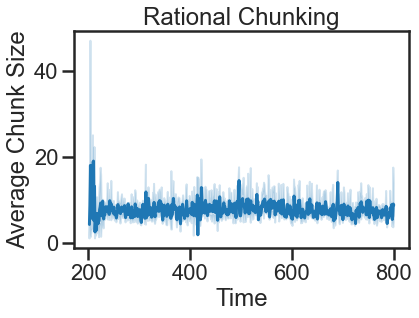

In [234]:
condition = 'ind'
palette = sns.color_palette("tab10")
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="trialnumber", y="chunksize(smoothed)", color = palette[0], data=RC_learn[(RC_learn['condition'] == condition) & (RC_learn['trialnumber']>201) & (RC_learn['trialnumber']<=800)])
plt.title('Rational Chunking')
plt.ylabel('Average Chunk Size')
plt.xlabel('Time')

If data is not smoothed, then associative learning produces very noisy chunks. 

Text(0.5, 0, 'Time')

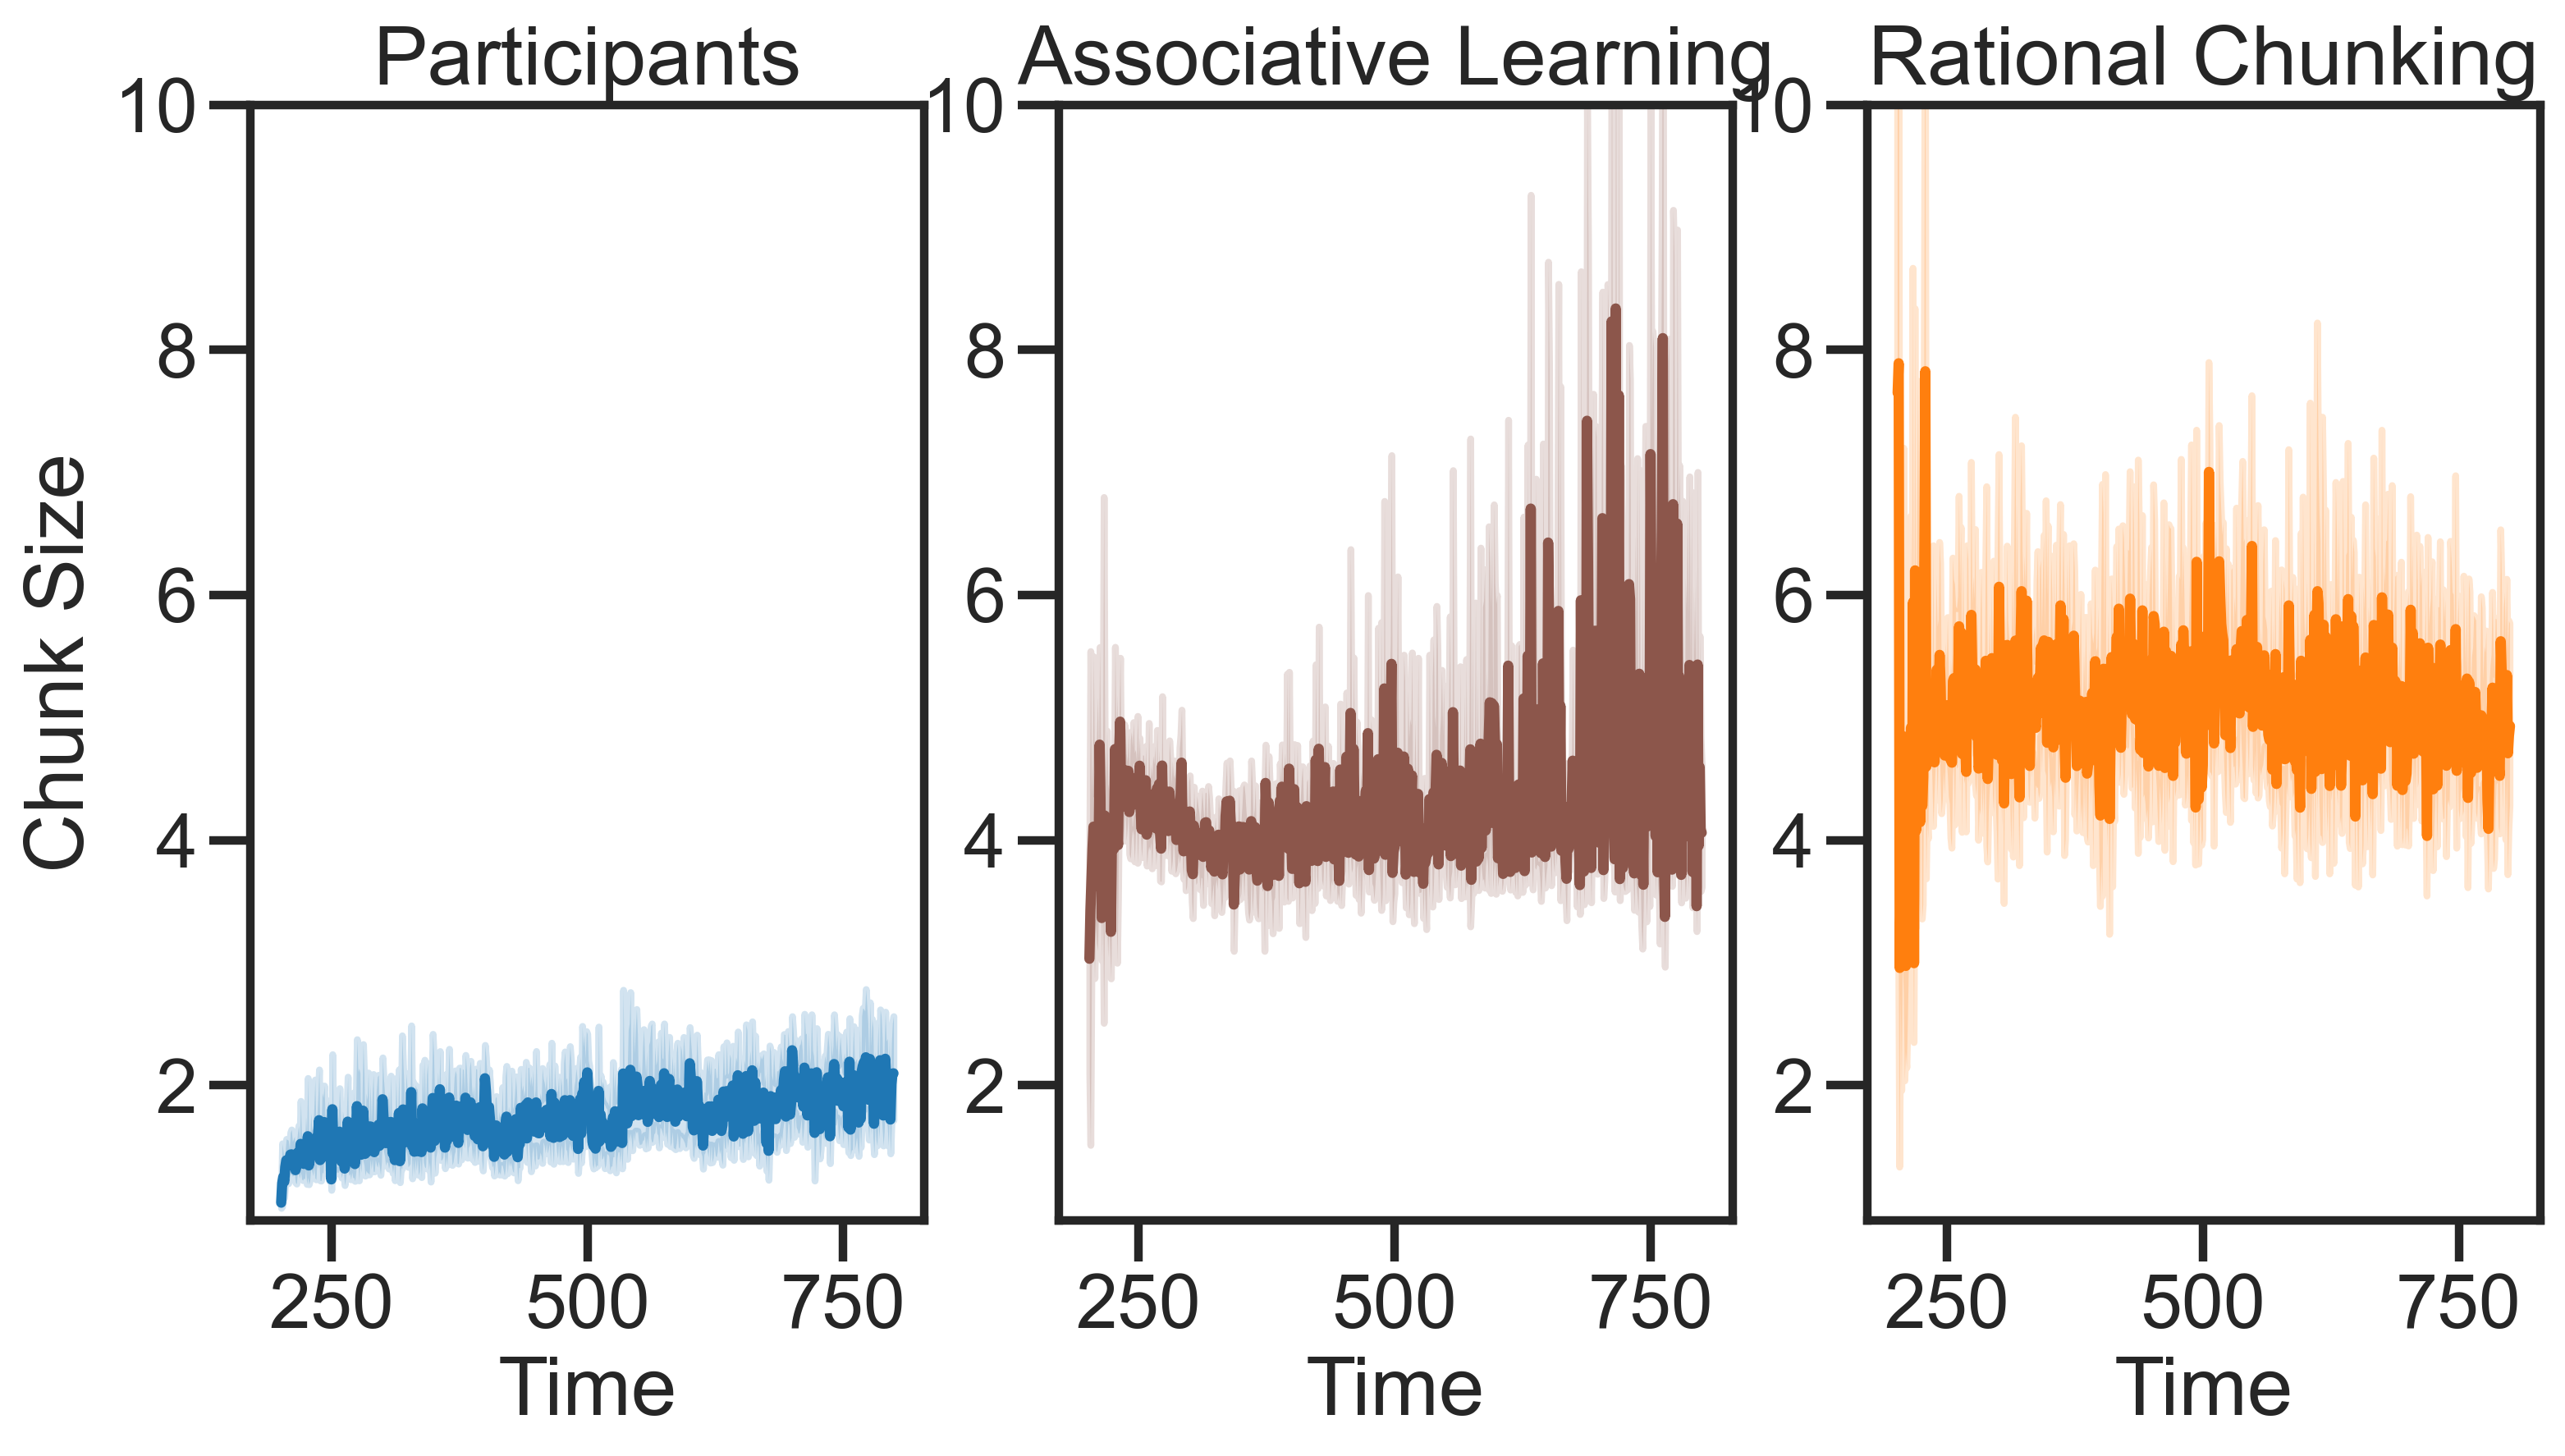

In [235]:
plt.figure(figsize = (12,6),dpi = 300)
plt.subplot(1,3,1)
sns.set_style("ticks")
sns.set_context("poster")

g = sns.lineplot(x="time", y="chunksize",color = palette[0], data=dfc3)
plt.title('Participants')
plt.ylabel('Chunk Size')
plt.ylim([0.9,10])
plt.xlabel('Time')

plt.subplot(1,3,2)
g = sns.lineplot(x="trialnumber", y="chunksize(smoothed)", color = palette[5], data=AL_learn[(AL_learn['condition'] == 'c3') & (AL_learn['trialnumber']>201) & (AL_learn['trialnumber']<=800)])
plt.title('Associative Learning')
plt.ylabel('')
plt.ylim([0.9,10])
plt.xlabel('Time')

plt.subplot(1,3,3)
g = sns.lineplot(x="trialnumber", y="chunksize(smoothed)", color = palette[2], data=RC_learn[(RC_learn['condition'] == 'c3') & (RC_learn['trialnumber']>201) & (RC_learn['trialnumber']<=800)])
plt.title('Rational Chunking')
plt.ylabel('')
plt.ylim([0.9,10])
plt.xlabel('Time')


Text(0.5, 0, 'Time')

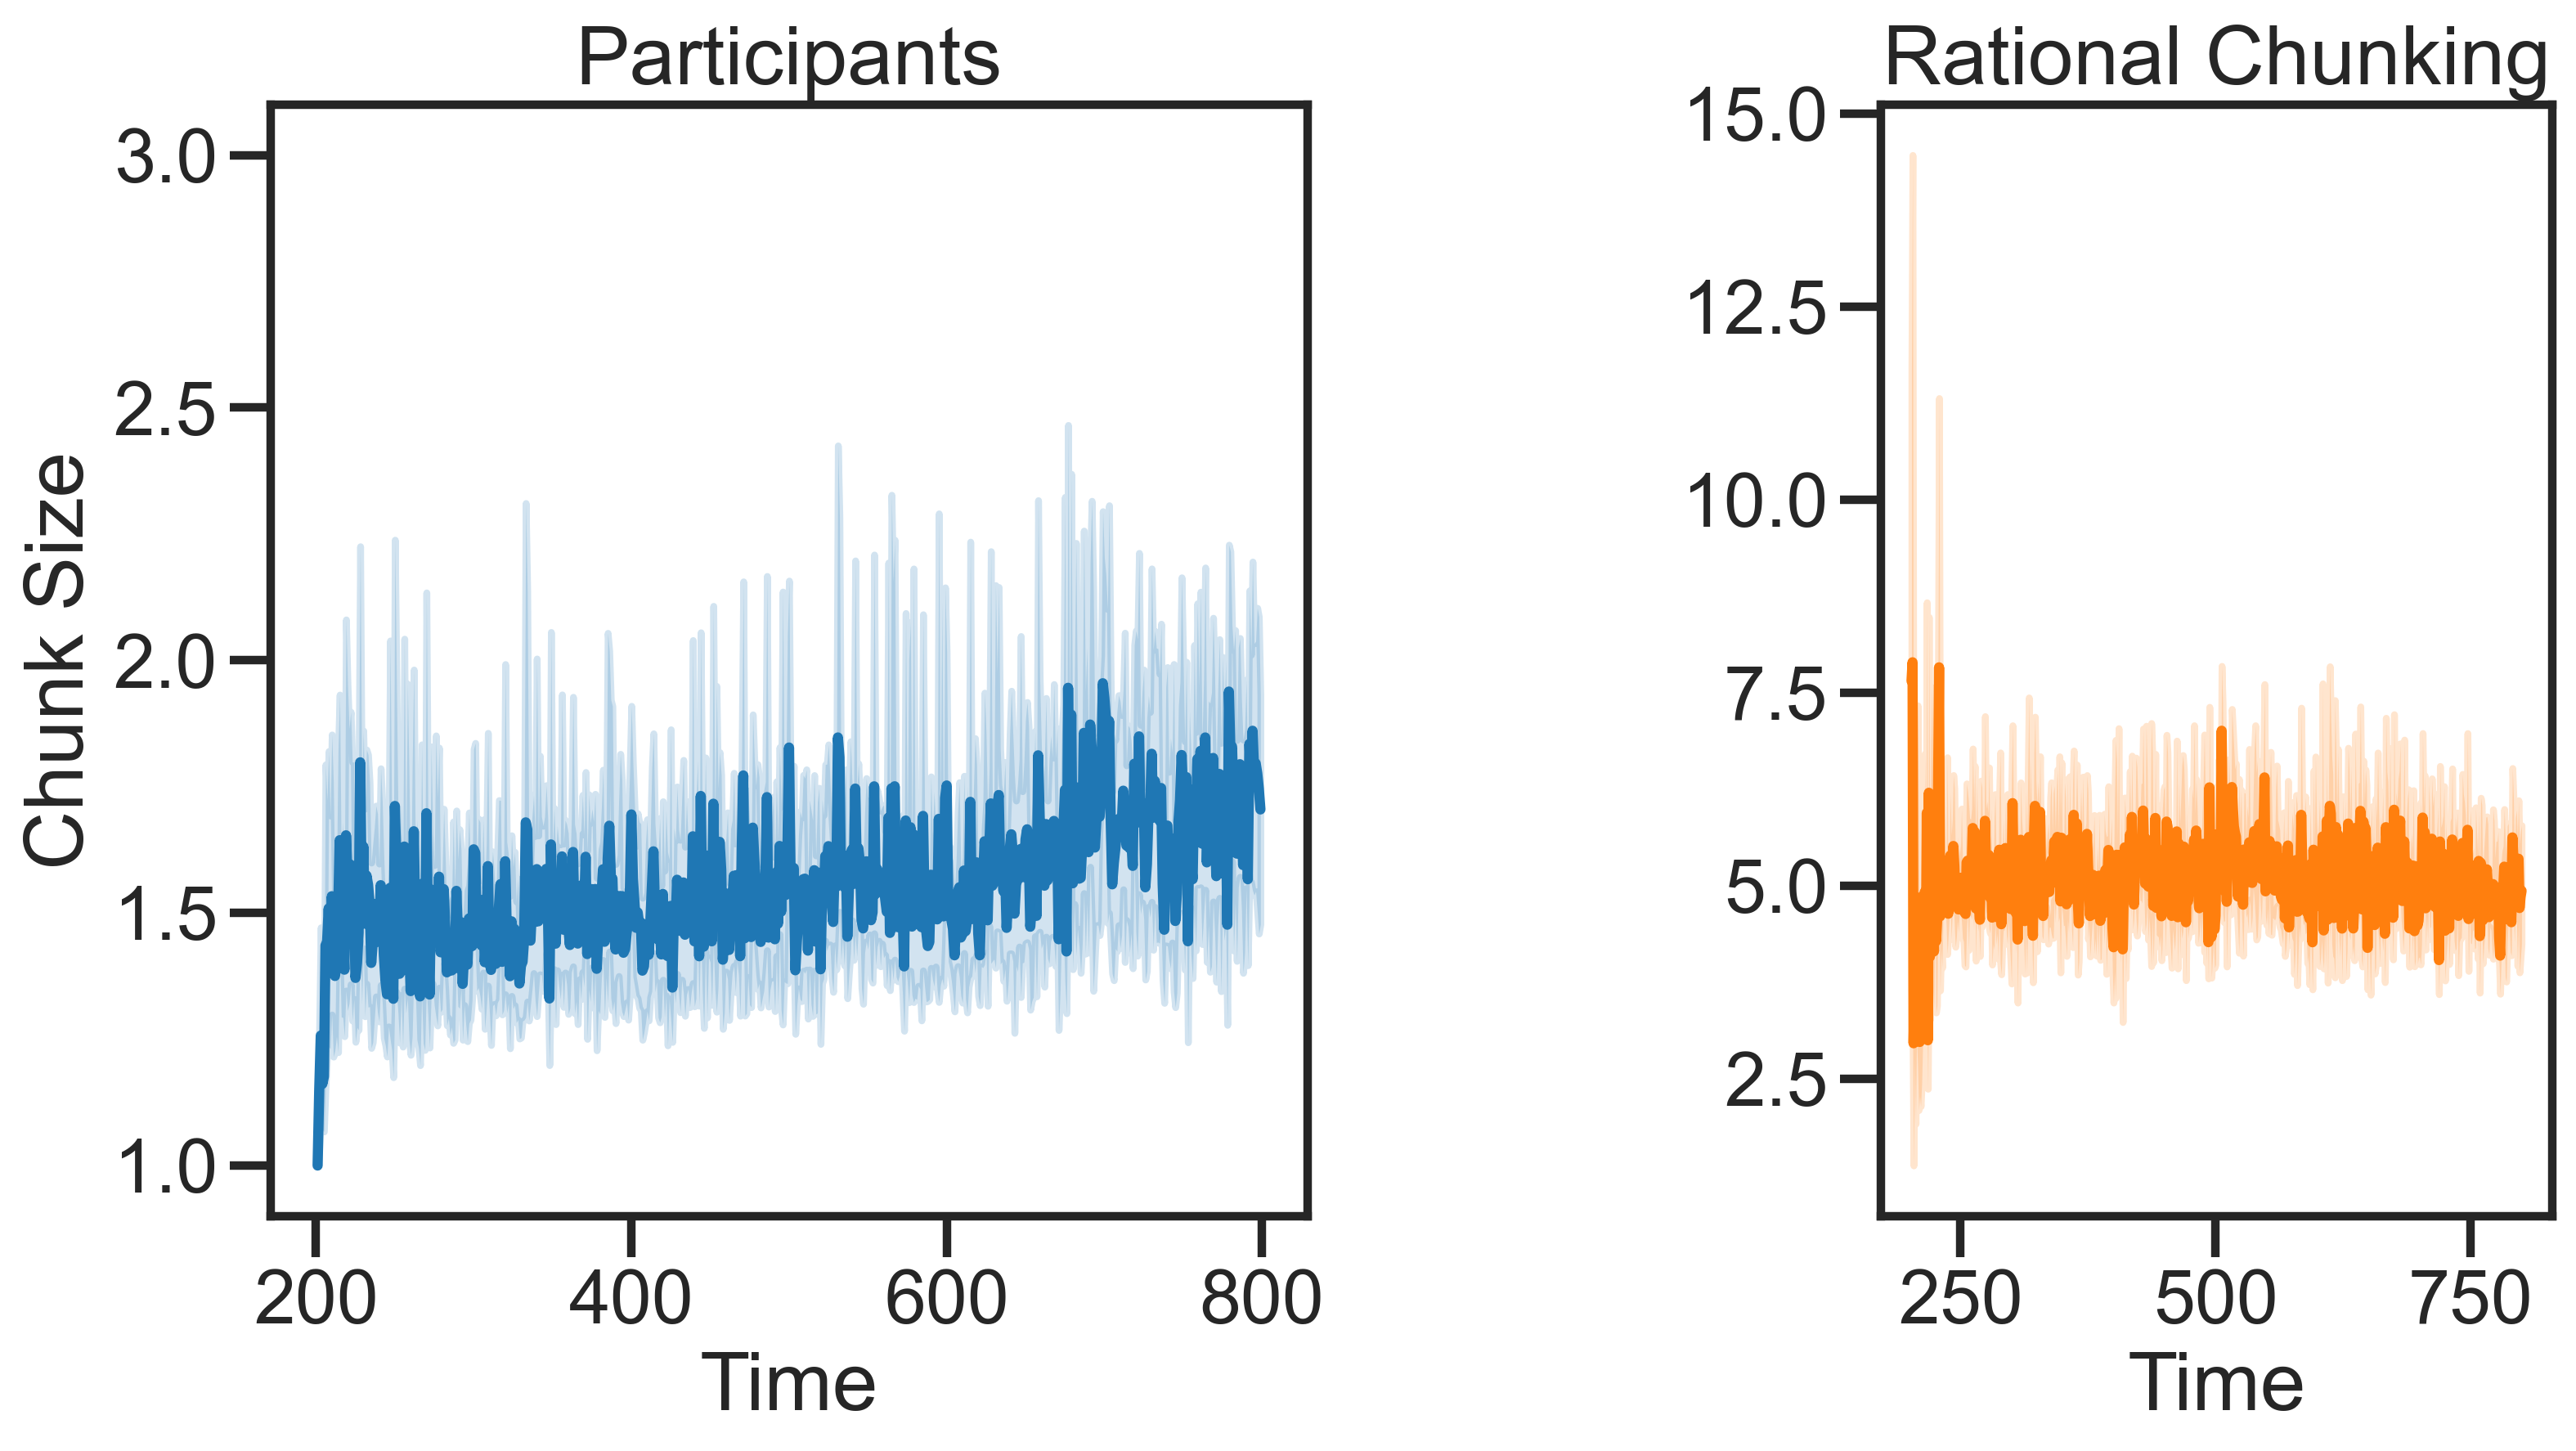

In [237]:
plt.figure(figsize = (12,6),dpi = 300)
plt.subplot(1,3,1)
g = sns.lineplot(x="time", y="chunksize",color = palette[0], data=dfc2)
plt.title('Participants')
plt.ylim([0.9,3.1])
plt.ylabel('Chunk Size')
plt.xlabel('Time')

plt.subplot(1,3,2)
sns.set_style("ticks")
g = sns.lineplot(x="trialnumber", y="chunksize(smoothed)", color = palette[5], data=AL_learn[(AL_learn['condition'] == 'c2') & (AL_learn['trialnumber']>201) & (AL_learn['trialnumber']<=800)])
plt.title('Associative Learning')
plt.ylabel('')
plt.ylim([0.9,3.1])
plt.xlabel('Time')

plt.subplot(1,3,3)
g = sns.lineplot(x="trialnumber", y="chunksize(smoothed)", color = palette[2], data=RC_learn[(RC_learn['condition'] == 'c3') & (RC_learn['trialnumber']>201) & (RC_learn['trialnumber']<=800)])
plt.title('Rational Chunking')
plt.ylabel('')
plt.xlabel('Time')




Text(0.5, 0, 'Time')

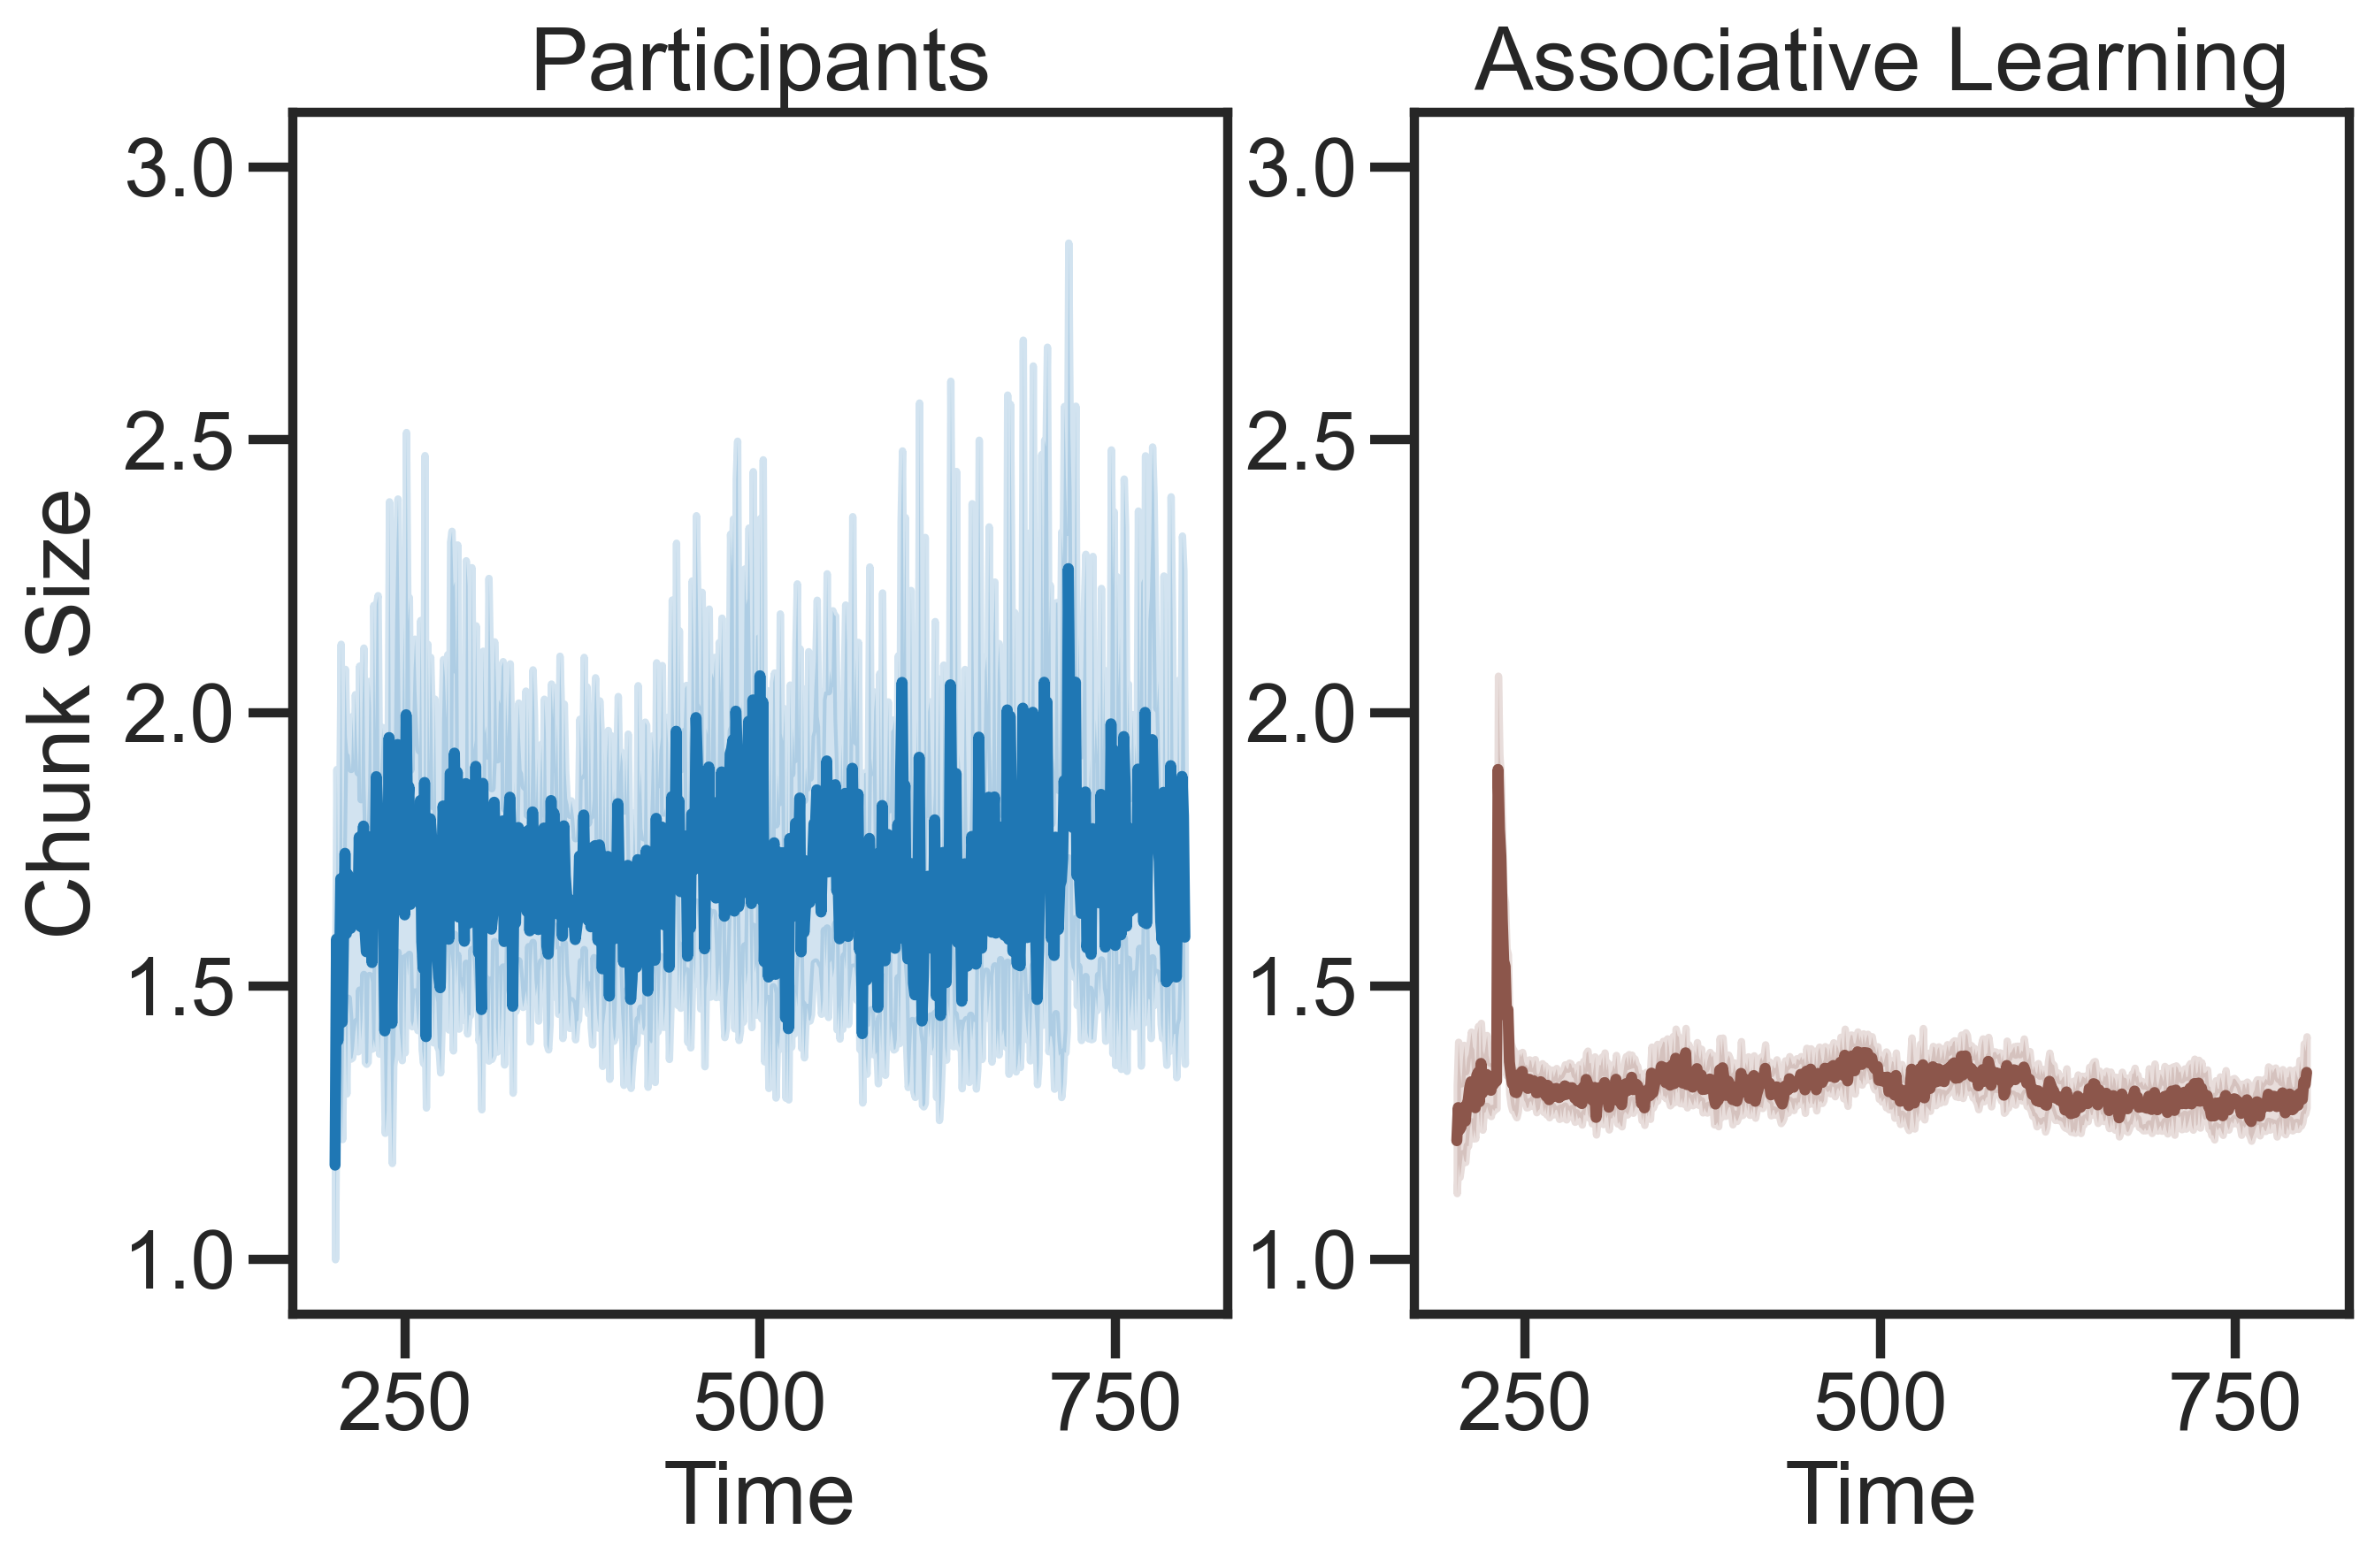

In [207]:
plt.figure(figsize = (10,6),dpi = 300)
sns.set_style("ticks")
sns.set_context("paper")
plt.subplot(1,3,1)

g = sns.lineplot(x="time", y="chunksize",color = palette[0], data=dfind)
plt.title('Participants')
plt.ylabel('Chunk Size')
plt.ylim([0.9,3.1])


plt.xlabel('Time')

plt.subplot(1,3,2)
condition = 'ind'

g = sns.lineplot(x="trialnumber", y="chunksize(smoothed)", color = palette[5], data=AL_learn[(AL_learn['condition'] == condition) & (AL_learn['trialnumber']>201) & (AL_learn['trialnumber']<=800)])
plt.title('Associative Learning')
plt.ylabel('')
plt.ylim([0.9,3.1])

plt.xlabel('Time')


plt.subplot(1,3,3)
g = sns.lineplot(x="trialnumber", y="chunksize(smoothed)", color = palette[2], data=RC_learn[(RC_learn['condition'] == 'c3') & (RC_learn['trialnumber']>201) & (RC_learn['trialnumber']<=800)])
plt.title('Rational Chunking')
plt.ylabel('')
plt.xlabel('Time')

# Evaluating Chunk Reuse

In [161]:
dff = pd.read_csv('../Data/exp1_associative_learning_rt_classified.csv')
subject_ids = list(np.unique(dff['id']))
keydff = dff['keyassignment'].str.split(r"\[|]|'|,", expand = True) # spilt key index to identify keys

indep_chunks = {}
c3_chunks = {}# dictionary to record chunk 3
c2_chunks = {}# dictionary to record chunk2

idx = 0
for subject_id in subject_ids: 
    if dff[dff['id'] == subject_id]['condition'].tolist()[0] == 2: # [12] [3] [4] '
        chunk_collect = c2_chunks    
    if dff[dff['id'] == subject_id]['condition'].tolist()[0] == 1: # [123] [4]'
        chunk_collect = c3_chunks    
    if dff[dff['id'] == subject_id]['condition'].tolist()[0] == 0: # [1] [2] [3] [4]
        chunk_collect = indep_chunks
    # process chunks and load them in the chunk collect
    name = str(subject_id)
    chunk_collect[name] = []
    # iterate in every block, single chunk are recorded by iteself.
    for block in range(1,11):
        i = 0
        for trial in range(1,101):
            chunk = []# initiate with an empty chunk 
            this_row = dff[(dff['id'] == subject_id) & (dff['trialcollect'] == trial) & (dff['block'] == block)]
            if this_row['withinchunk'].tolist()[0] == False:
                # search back in time to find another false:
                index = dff.index[(dff['id'] == subject_id) & (dff['trialcollect'] == trial) & (dff['block'] == block)].tolist()[0]
                keypress = identify_press(dff, keydff, index)
                chunk.append(keypress)
                next_trial = trial + 1
                if next_trial <=100: 
                    nextrow = dff[(dff['id'] == subject_id) & (dff['trialcollect'] == next_trial) & (dff['block'] == block)]
                    while nextrow['withinchunk'].tolist()[0] == True and next_trial<=100:
                        index = dff.index[(dff['id'] == subject_id) & (dff['trialcollect'] == next_trial) & (dff['block'] == block)].tolist()[0]
                        keypress = identify_press(dff, keydff, index)
                        chunk.append(keypress)
                        next_trial = next_trial + 1
                        nextrow = dff[(dff['id'] == subject_id) & (dff['trialcollect'] == next_trial) & (dff['block'] == block)]
                        if len(nextrow)==0:
                            break
                chunk_collect[name].append(chunk)
                i = i + len(chunk)
            else:
                pass

c1c2c3 = {'c2':c2_chunks, 'c3':c3_chunks, 'ind':indep_chunks}
with open('../data/chunk_exp1_associative_learning.pickle', 'wb') as handle:
    pickle.dump(c1c2c3, handle)

In [183]:
def evaluate_reuse_p(chunklist):
    def isSublist(a,b):
        for i in range(len(b)-len(a)+1):
            if b[i:i+len(a)] == a:
                return True
        return False
    # take the chunking list of to evaluate the reuse probability of this agent
    reuse_history = []
    for i in range(0,len(chunklist)):
        thischunk = chunklist[i]
        if len(thischunk)>=3:
            reuse = 0
            for prevchunk in chunklist[i-30:i]:
                if len(prevchunk) >=2:
                    if isSublist(prevchunk,thischunk):
                        reuse = 1
            #print(thischunk)
            #print(chunklist[i-30:i])
            #print(reuse)
            reuse_history.append(reuse)
            
    return np.mean(reuse_history) if len(reuse_history)>0 else 0
            


In [185]:
AL_reuse = {}
AL_reuse['id'] = []
AL_reuse['condition'] = []
AL_reuse['reuse_p'] = []
AL_reuse['not_reuse_p'] = []

for condi in list(c1c2c3.keys()):
    for ID in list(c1c2c3[condi].keys()):
        reusep = evaluate_reuse_p(c1c2c3[condi][ID])
        AL_reuse['id'].append(ID)
        AL_reuse['condition'].append(condi)
        AL_reuse['reuse_p'].append(reusep)
        AL_reuse['not_reuse_p'].append(1 - reusep)
        
AL_reuse = pd.DataFrame.from_dict(AL_reuse)
AL_reuse.to_csv("../data/chunk_reuse_exp1_associative_learning.csv")